In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify outputs
results_dir = "results/kato/2018-08-30"

In [3]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [5]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, m, ztr) in enumerate(zip(ys, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

# Dimensionality reduction on $\Delta$F/F 

In [19]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
pcas = []
scores = []
for D in range(2, 31, 2):
    print("D = ", D)
    # Fit PCA with missing data imputation on the training data
    pca, _ = pca_with_imputation(D, train_ys, train_ms)
    pcas.append(pca)
    
    score = 0
    for y, m in zip(val_ys, val_ms):
        # Estimate the missing data
        yhat = y.copy()
        for _ in range(20):
            yhat[~m] = pca.inverse_transform(pca.transform(yhat))[~m]
        
        # Score the reconstruction
        yhat = pca.inverse_transform(pca.transform(yhat))
        score += -0.5 * np.mean((y[m] - yhat[m])**2)
        
    scores.append(score)

D =  2
D =  4
D =  6
D =  8
D =  10
D =  12
D =  14
D =  16
D =  18
D =  20
D =  22
D =  24
D =  26
D =  28
D =  30


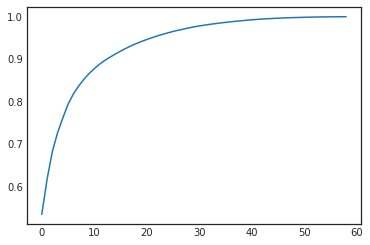

In [27]:
pca, _ = pca_with_imputation(N, ys, ms)
plt.plot(np.arange(N), np.cumsum(pca.explained_variance_ratio_))

In [30]:
np.sum(np.cumsum(pca.explained_variance_ratio_) < .9)

13